# Neural networks with residual blocks 
Several architectures were tested in the process. One of the major benefits of a very deep network is that it can represent very complex functions.
However, a huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.
More specifically, during gradient descent, as we backprop from the final layer back to the first layer, we are multiplying by the weight matrix on each step. If the gradients are small, due to large number of multiplications, the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and “explode” to take very large values).
###Using deeper networks is degrading the performance of the model.
The solution is to use skip connections.
Using deeper networks is degrading the performance of the model. 
Adding additional / new layers would not hurt the model’s performance as regularisation will skip over them if those layers were not useful.
If the additional / new layers were useful, even with the presence of regularisation, the weights or kernels of the layers will be non-zero and model performance could increase slightly. 

#Mounting GD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Utils used for experiments
##On the final stage, those are to be inlcuded in a separate .py file

In [ ]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras

#Loading pre-computed features and corresponding labels

In [3]:
import ast
featuresdf = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release/features.csv",index_col=[0])
featuresdf['feature'] = featuresdf['feature'].apply(lambda x: np.array(ast.literal_eval(x))) 


##Converting features to numpy arrays


In [4]:
features_temp = featuresdf['feature']
X = [l.tolist() for l in features_temp]
X = np.array(X)
X.shape

(5531, 40, 517)

Encode labels to onehot

In [5]:
from sklearn.preprocessing import LabelEncoder
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [6]:
rounded_labels= np.unique(le.inverse_transform(np.argmax(yy, axis=1)))
rounded_labels

array(['ang', 'hap', 'neu', 'sad'], dtype='<U3')

#RESNET-50
Inspired by Andrew Ng dnn course

In [8]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters 
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1),
               padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=(1, 1), 
               strides=(s, s), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1),
               padding='same', name=conv_name_base + '2b', 
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s),
                        padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [9]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
def ResNet50(input_shape=(40,517,1), classes=4):
    X_input = Input(input_shape)

    # Zero-Padding 
    X = ZeroPadding2D((3, 3))(X_input)
    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform())(X)
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    return model

In [ ]:
keras.utils.plot_model(ResNet50(), "/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/resnet50.png", show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ResNet50().summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 517, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 46, 523, 1)  0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 20, 259, 64)  3200        ['zero_padding2d_2[0][0]']       
                                                                                           

In [ ]:
def k_fold_fit_re(model_type, X, yy, lr = 0.000001, folds=10, numepoch = 50, batchsize = 32):
  from sklearn.model_selection import KFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from tensorflow.keras.optimizers import SGD
  from sklearn.metrics import f1_score
  from functools import reduce
  #pred and ground truth for overall conf matrix
  truth = []
  predicted = []
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=folds, shuffle=True)
  fold_no = 1
  for train, test in kfold.split(X, yy):
    model = ResNet50()
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(X[train],
                yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate(X[test], yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix construction
    y_pred = np.argmax(model.predict(X[test]), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #append predicted and ground truth to corresponding lists
    truth.append(yy[test].argmax(axis=1).tolist())
    predicted.append(y_pred.tolist())
    #conf matrix contd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')
  #flatten the nested lists
  print('Confusion matrix over all folders')
  truth = reduce(lambda x,y: x+y, truth)
  predicted = reduce(lambda x,y:x+y, predicted)
  matrix = metrics.confusion_matrix(truth, predicted)
  rounded_labels= np.unique(le.inverse_transform(np.argmax(yy, axis=1)))
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
156/156 [==============================] - 15s 64ms/step - loss: 1.4649 - accuracy: 0.3633
Epoch 2/100
156/156 [==============================] - 10s 63ms/step - loss: 1.2966 - accuracy: 0.4149
Epoch 3/100
156/156 [==============================] - 10s 63ms/step - loss: 1.2615 - accuracy: 0.4282
Epoch 4/100
156/156 [==============================] - 10s 63ms/step - loss: 1.2386 - accuracy: 0.4302
Epoch 5/100
156/156 [==============================] - 10s 63ms/step - loss: 1.2042 - accuracy: 0.4595
Epoch 6/100
156/156 [==============================] - 10s 63ms/step - loss: 1.1954 - accuracy: 0.4643
Epoch 7/100
156/156 [==============================] - 10s 63ms/step - loss: 1.1783 - accuracy: 0.4665
Epoch 8/100
156/156 [==============================] - 10s 63ms/step - loss: 1.1626 - accuracy: 0.4714
Epoch 9/100
156/156 [==============================] - 10s 63ms/step - loss: 1.

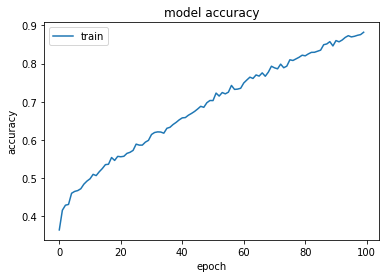

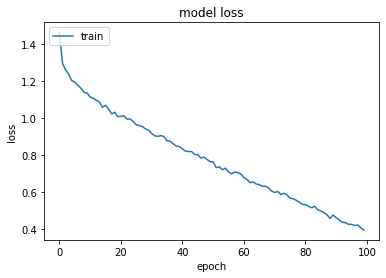

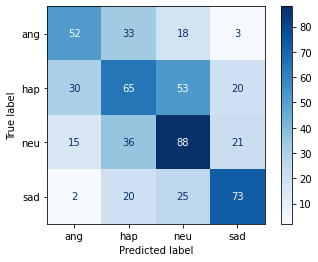

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 50.18050670623779 (+- 0.0)
> Loss: 1.2207920551300049
> F1: 50.06971344075989
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
156/156 [==============================] - 16s 62ms/step - loss: 1.3892 - accuracy: 0.3765
Epoch 2/100
156/156 [==============================] - 10s 63ms/step - loss: 1.2719 - accuracy: 0.4168
Epoch 3/100
156/156 [==============================] - 10s 62ms/step - loss: 1.2244 - accuracy: 0.4570
Epoch 4/100
156/156 [==============================] - 10s 62ms/step - loss:

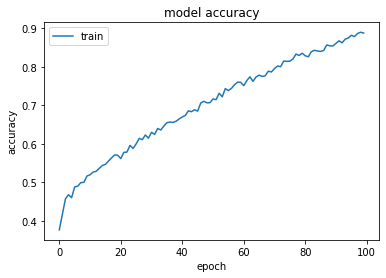

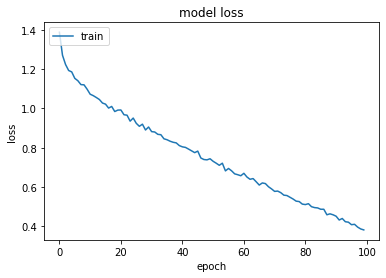

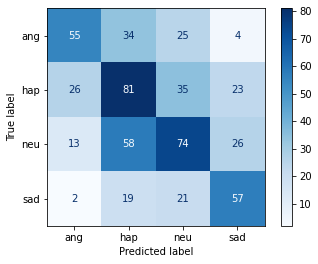

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2955477237701416 - Accuracy: 48.2820987701416% - F1: 48.3110410538516
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 49.2313027381897 (+- 0.9492039680480957)
> Loss: 1.2581698894500732
> F1: 49.19037724730575
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
156/156 [==============================] - 15s 62ms/step - loss: 1.4575 - accuracy: 0.3574
Epoch 2/100
156/156 [==============================] - 10s 62ms/step - loss: 1.2988 - accuracy: 0.4094
Epo

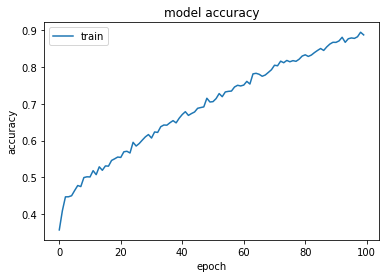

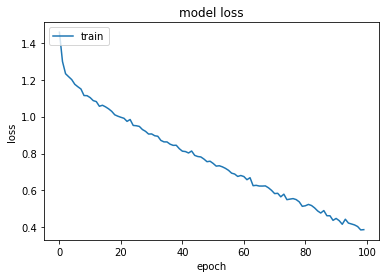

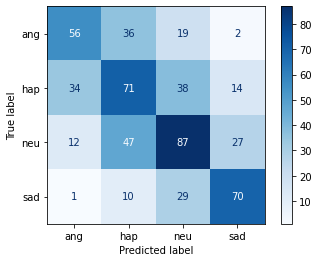

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2955477237701416 - Accuracy: 48.2820987701416% - F1: 48.3110410538516
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1333787441253662 - Accuracy: 51.35623812675476% - F1: 51.37479239644789
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 49.93961453437805 (+- 1.2665188443964477)
> Loss: 1.2165728410085042
> F1: 49.918515630353134
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
156/156 [======================

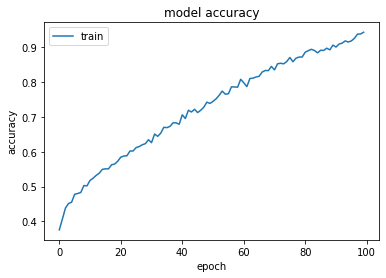

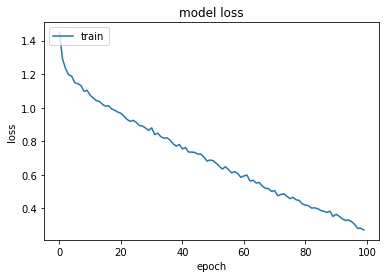

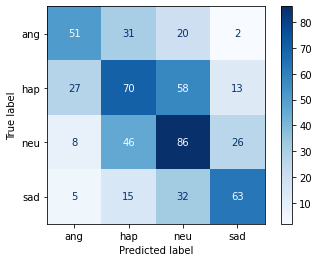

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2955477237701416 - Accuracy: 48.2820987701416% - F1: 48.3110410538516
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1333787441253662 - Accuracy: 51.35623812675476% - F1: 51.37479239644789
------------------------------------------------------------------------
> Fold 4 - Loss: 1.301796555519104 - Accuracy: 48.82459342479706% - F1: 48.95299077959614
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 49.6608592569828 (+- 1.1984014358450972)
> Loss: 1.2378787696361542
> F1: 49.677134417663886
---------------------------------------------------

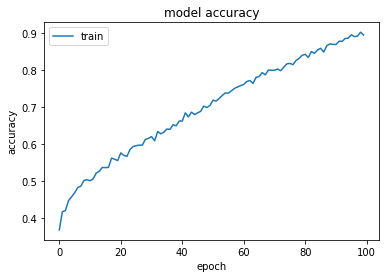

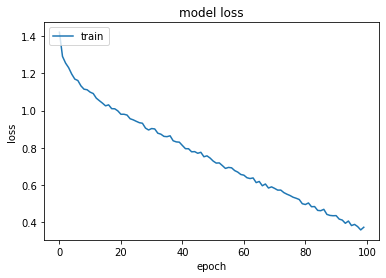

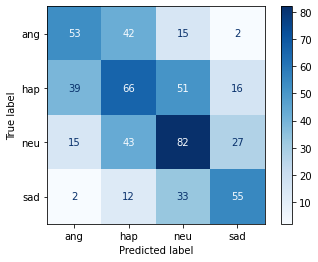

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2955477237701416 - Accuracy: 48.2820987701416% - F1: 48.3110410538516
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1333787441253662 - Accuracy: 51.35623812675476% - F1: 51.37479239644789
------------------------------------------------------------------------
> Fold 4 - Loss: 1.301796555519104 - Accuracy: 48.82459342479706% - F1: 48.95299077959614
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2521998882293701 - Accuracy: 46.292948722839355% - F1: 46.245623005907014
------------------------------------------------------------------------
Average scores for a

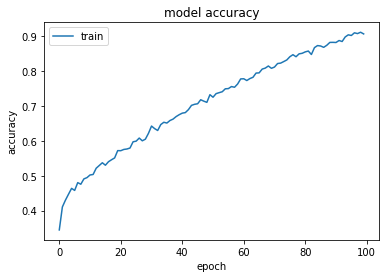

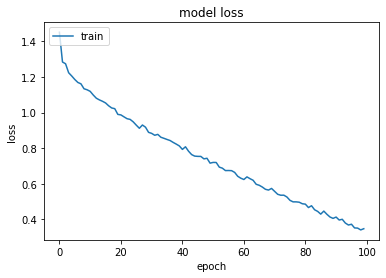

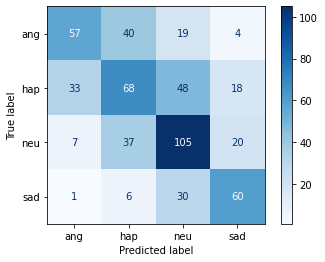

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2955477237701416 - Accuracy: 48.2820987701416% - F1: 48.3110410538516
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1333787441253662 - Accuracy: 51.35623812675476% - F1: 51.37479239644789
------------------------------------------------------------------------
> Fold 4 - Loss: 1.301796555519104 - Accuracy: 48.82459342479706% - F1: 48.95299077959614
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2521998882293701 - Accuracy: 46.292948722839355% - F1: 46.245623005907014
------------------------------------------------------------------------
> Fold 6 - Loss: 1.1

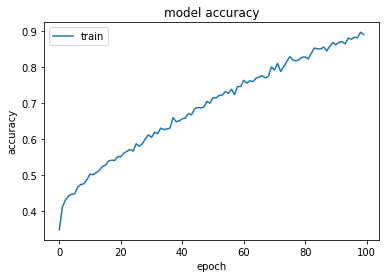

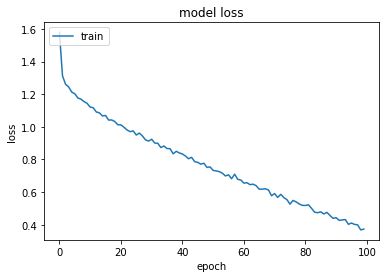

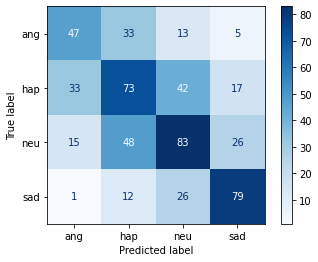

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2955477237701416 - Accuracy: 48.2820987701416% - F1: 48.3110410538516
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1333787441253662 - Accuracy: 51.35623812675476% - F1: 51.37479239644789
------------------------------------------------------------------------
> Fold 4 - Loss: 1.301796555519104 - Accuracy: 48.82459342479706% - F1: 48.95299077959614
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2521998882293701 - Accuracy: 46.292948722839355% - F1: 46.245623005907014
------------------------------------------------------------------------
> Fold 6 - Loss: 1.1

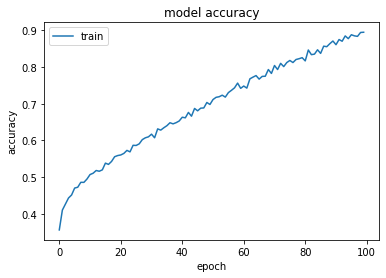

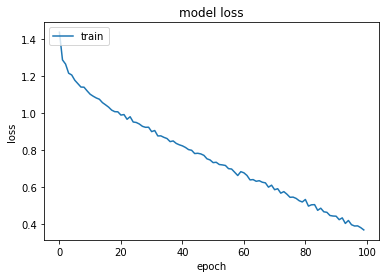

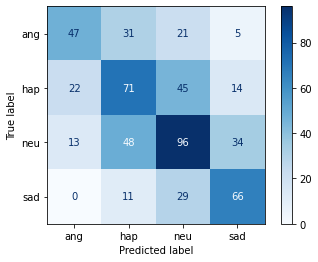

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2955477237701416 - Accuracy: 48.2820987701416% - F1: 48.3110410538516
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1333787441253662 - Accuracy: 51.35623812675476% - F1: 51.37479239644789
------------------------------------------------------------------------
> Fold 4 - Loss: 1.301796555519104 - Accuracy: 48.82459342479706% - F1: 48.95299077959614
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2521998882293701 - Accuracy: 46.292948722839355% - F1: 46.245623005907014
------------------------------------------------------------------------
> Fold 6 - Loss: 1.1

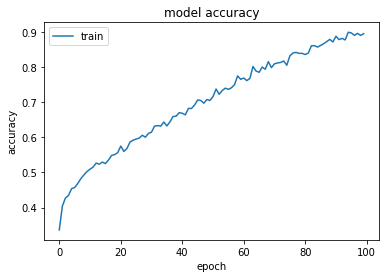

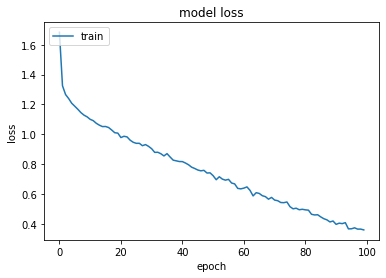

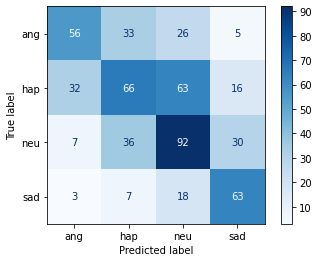

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2955477237701416 - Accuracy: 48.2820987701416% - F1: 48.3110410538516
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1333787441253662 - Accuracy: 51.35623812675476% - F1: 51.37479239644789
------------------------------------------------------------------------
> Fold 4 - Loss: 1.301796555519104 - Accuracy: 48.82459342479706% - F1: 48.95299077959614
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2521998882293701 - Accuracy: 46.292948722839355% - F1: 46.245623005907014
------------------------------------------------------------------------
> Fold 6 - Loss: 1.1

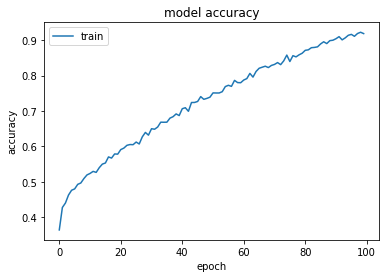

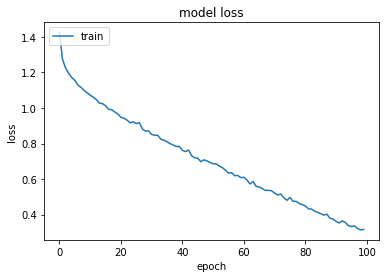

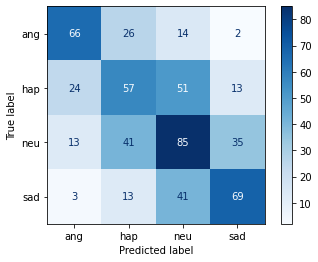

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2207920551300049 - Accuracy: 50.18050670623779% - F1: 50.06971344075989
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2955477237701416 - Accuracy: 48.2820987701416% - F1: 48.3110410538516
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1333787441253662 - Accuracy: 51.35623812675476% - F1: 51.37479239644789
------------------------------------------------------------------------
> Fold 4 - Loss: 1.301796555519104 - Accuracy: 48.82459342479706% - F1: 48.95299077959614
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2521998882293701 - Accuracy: 46.292948722839355% - F1: 46.245623005907014
------------------------------------------------------------------------
> Fold 6 - Loss: 1.1

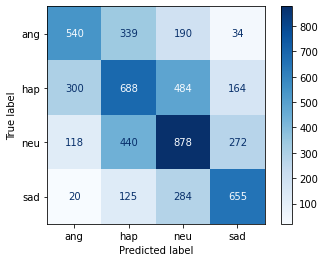

In [ ]:
k_fold_fit_re('Resnet50', X, yy, folds=10, numepoch = 100, batchsize = 32)

In [ ]:
def strat_k_fold_fit_re(model_type,X, yy, folds=10, lr=0.0001, numepoch = 50, batchsize = 32):
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from tensorflow.keras.optimizers import SGD
  from sklearn.preprocessing import LabelEncoder
  from sklearn.metrics import f1_score
  le = LabelEncoder()
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  # Define the stratified K-fold Cross Validator
  kfold = StratifiedKFold(n_splits=folds, shuffle=True)
  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(X, y):
    #label encoding comes after the split
    yy = to_categorical(le.fit_transform(y))
    model = ResNet50()
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model and save details to history
    history = model.fit(X[train], yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate(X[test], yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix
    y_pred = np.argmax(model.predict(X[test]), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #conf matrix ctnd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
156/156 [==============================] - 15s 63ms/step - loss: 1.5008 - accuracy: 0.3625
Epoch 2/100
156/156 [==============================] - 10s 63ms/step - loss: 1.2746 - accuracy: 0.4183
Epoch 3/100
156/156 [==============================] - 10s 63ms/step - loss: 1.2288 - accuracy: 0.4406
Epoch 4/100
156/156 [==============================] - 10s 63ms/step - loss: 1.1998 - accuracy: 0.4507
Epoch 5/100
156/156 [==============================] - 10s 63ms/step - loss: 1.1795 - accuracy: 0.4661
Epoch 6/100
156/156 [==============================] - 10s 63ms/step - loss: 1.1513 - accuracy: 0.4704
Epoch 7/100
156/156 [==============================] - 10s 63ms/step - loss: 1.1366 - accuracy: 0.4862
Epoch 8/100
156/156 [==============================] - 10s 63ms/step - loss: 1.1358 - accuracy: 0.4826
Epoch 9/100
156/156 [==============================] - 10s 63ms/step - loss: 1.

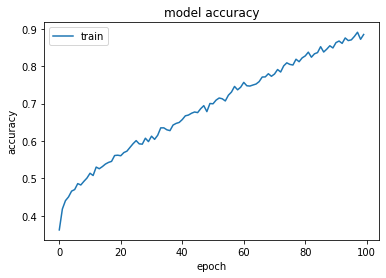

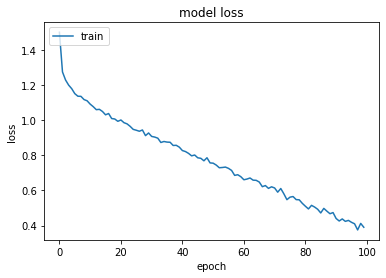

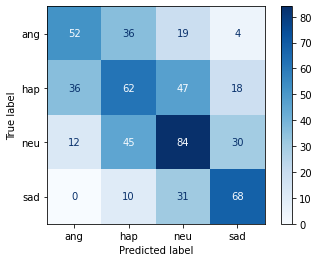

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 48.01444113254547 (+- 0.0)
> Loss: 1.2680513858795166
> F1: 47.837578810139746
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
156/156 [==============================] - 15s 62ms/step - loss: 1.4955 - accuracy: 0.3491
Epoch 2/100
156/156 [==============================] - 10s 63ms/step - loss: 1.2779 - accuracy: 0.4237
Epoch 3/100
156/156 [==============================] - 10s 62ms/step - loss: 1.2518 - accuracy: 0.4235
Epoch 4/100
156/156 [==============================] - 10s 62ms/step - lo

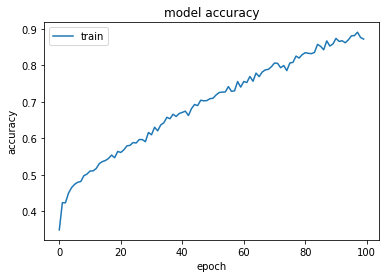

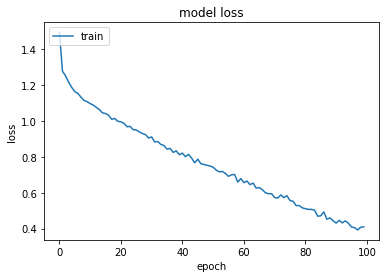

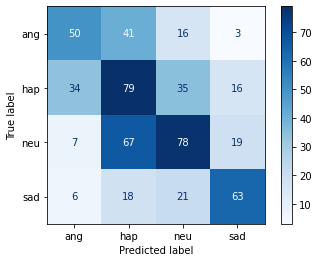

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.1915947198867798 - Accuracy: 48.82459342479706% - F1: 49.109434073379276%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 48.419517278671265 (+- 0.40507614612579346)
> Loss: 1.2298230528831482
> F1: 48.47350644175951
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
156/156 [==============================] - 15s 62ms/step - loss: 1.3738 - accuracy: 0.3811
Epoch 2/100
156/156 [==============================] - 10s 62ms/step - loss: 1.2655 - accuracy: 0

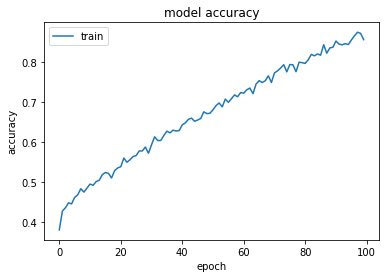

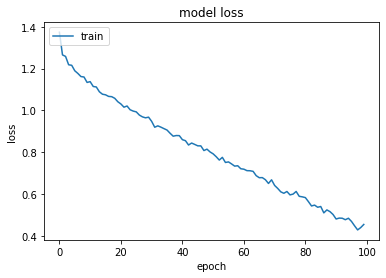

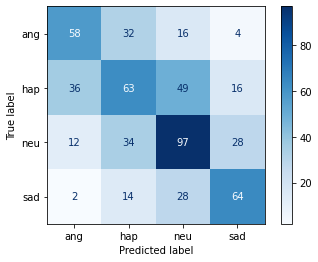

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.1915947198867798 - Accuracy: 48.82459342479706% - F1: 49.109434073379276%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.171012043952942 - Accuracy: 50.99457502365112% - F1: 50.73646597184154%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 49.277869860331215 (+- 1.2581452347237296)
> Loss: 1.210219383239746
> F1: 49.22782628512019
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
156/156 [=================

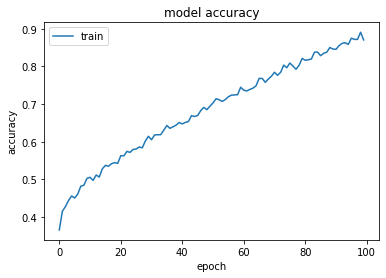

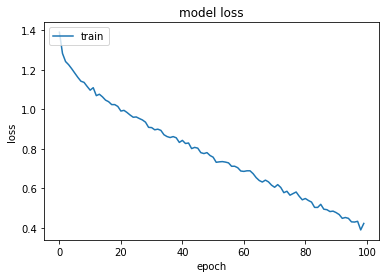

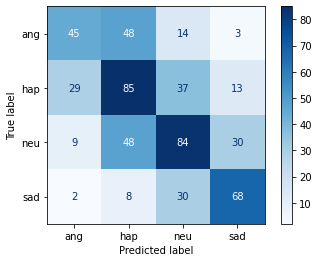

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.1915947198867798 - Accuracy: 48.82459342479706% - F1: 49.109434073379276%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.171012043952942 - Accuracy: 50.99457502365112% - F1: 50.73646597184154%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.1960885524749756 - Accuracy: 50.99457502365112% - F1: 50.88816689024672%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 49.707046151161194 (+- 1.3190049050611037)
> Loss: 1.2066866755485535
> F1: 49.64291143640182
------------------------------------------

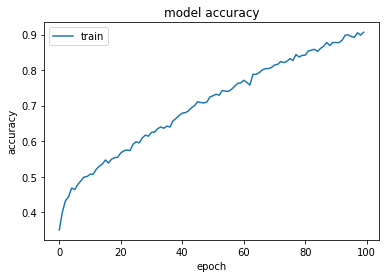

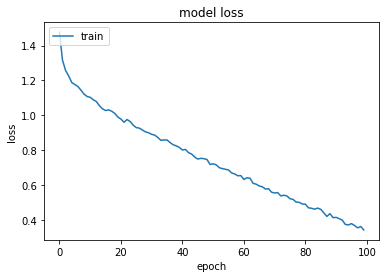

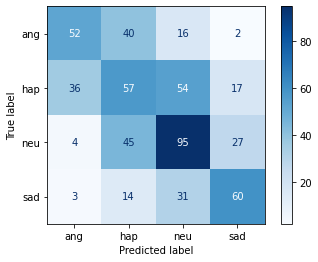

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.1915947198867798 - Accuracy: 48.82459342479706% - F1: 49.109434073379276%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.171012043952942 - Accuracy: 50.99457502365112% - F1: 50.73646597184154%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.1960885524749756 - Accuracy: 50.99457502365112% - F1: 50.88816689024672%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2985364198684692 - Accuracy: 47.739601135253906% - F1: 47.61649838454888%
------------------------------------------------------------------------
Average scor

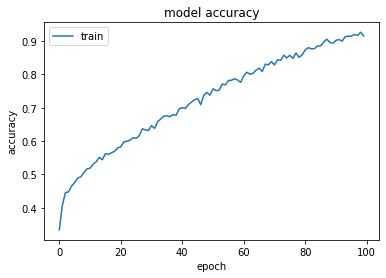

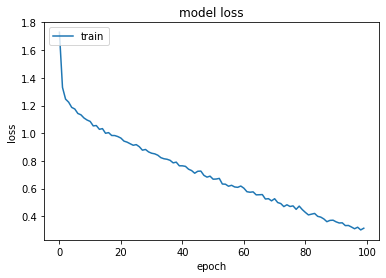

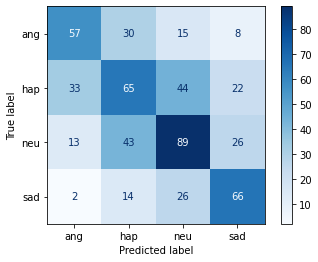

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.1915947198867798 - Accuracy: 48.82459342479706% - F1: 49.109434073379276%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.171012043952942 - Accuracy: 50.99457502365112% - F1: 50.73646597184154%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.1960885524749756 - Accuracy: 50.99457502365112% - F1: 50.88816689024672%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2985364198684692 - Accuracy: 47.739601135253906% - F1: 47.61649838454888%
------------------------------------------------------------------------
> Fold 6 - L

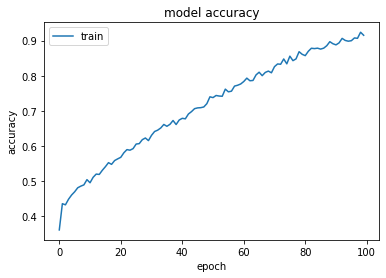

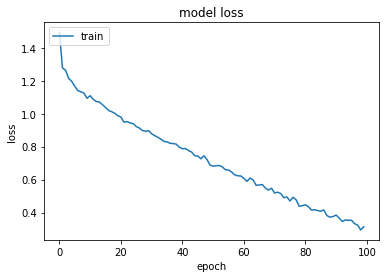

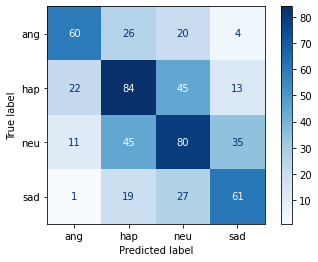

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.1915947198867798 - Accuracy: 48.82459342479706% - F1: 49.109434073379276%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.171012043952942 - Accuracy: 50.99457502365112% - F1: 50.73646597184154%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.1960885524749756 - Accuracy: 50.99457502365112% - F1: 50.88816689024672%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2985364198684692 - Accuracy: 47.739601135253906% - F1: 47.61649838454888%
------------------------------------------------------------------------
> Fold 6 - L

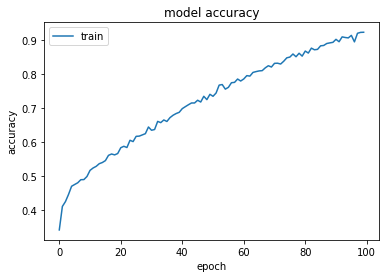

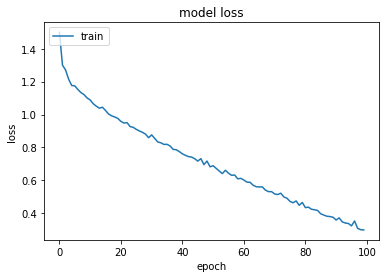

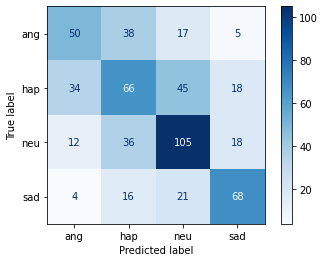

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.1915947198867798 - Accuracy: 48.82459342479706% - F1: 49.109434073379276%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.171012043952942 - Accuracy: 50.99457502365112% - F1: 50.73646597184154%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.1960885524749756 - Accuracy: 50.99457502365112% - F1: 50.88816689024672%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2985364198684692 - Accuracy: 47.739601135253906% - F1: 47.61649838454888%
------------------------------------------------------------------------
> Fold 6 - L

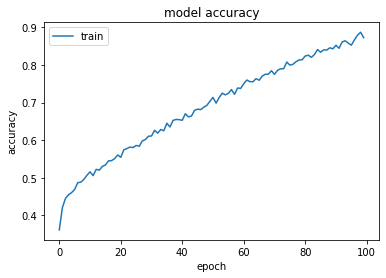

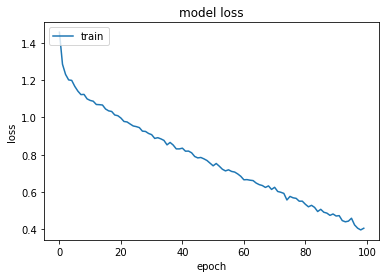

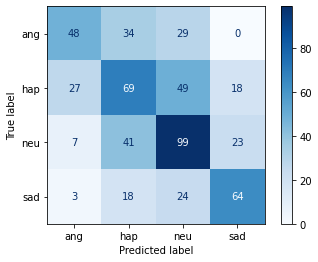

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.1915947198867798 - Accuracy: 48.82459342479706% - F1: 49.109434073379276%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.171012043952942 - Accuracy: 50.99457502365112% - F1: 50.73646597184154%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.1960885524749756 - Accuracy: 50.99457502365112% - F1: 50.88816689024672%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2985364198684692 - Accuracy: 47.739601135253906% - F1: 47.61649838454888%
------------------------------------------------------------------------
> Fold 6 - L

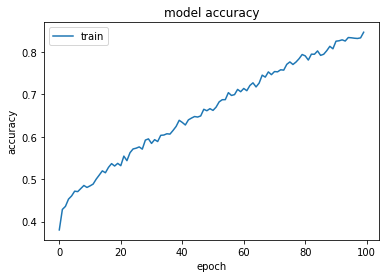

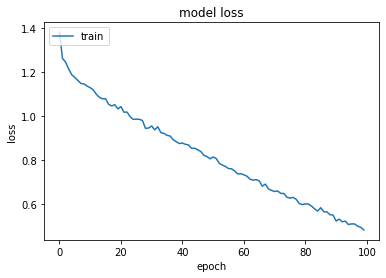

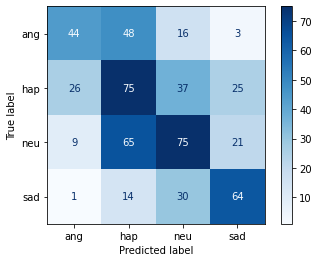

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2680513858795166 - Accuracy: 48.01444113254547% - F1: 47.837578810139746%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.1915947198867798 - Accuracy: 48.82459342479706% - F1: 49.109434073379276%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.171012043952942 - Accuracy: 50.99457502365112% - F1: 50.73646597184154%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.1960885524749756 - Accuracy: 50.99457502365112% - F1: 50.88816689024672%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2985364198684692 - Accuracy: 47.739601135253906% - F1: 47.61649838454888%
------------------------------------------------------------------------
> Fold 6 - L

In [ ]:
strat_k_fold_fit_re('Resnet50', X, yy, folds=10, lr=0.000001, numepoch = 100, batchsize = 32)

#Train the model over the whole dataset and save the model

In [ ]:
X.shape

(5531, 40, 517)

I decided to implement the "model checkpoint callback" to monitor and save the weights that provide maximum value for validation accuracy

Epoch 1/150
138/139 [============================>.] - ETA: 0s - loss: 1.5493 - accuracy: 0.3650
Epoch 1: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_resnet50.h5
139/139 [==============================] - 17s 85ms/step - loss: 1.5494 - accuracy: 0.3651 - val_loss: 1.4780 - val_accuracy: 0.2114
Epoch 2/150
138/139 [============================>.] - ETA: 0s - loss: 1.2863 - accuracy: 0.4119
Epoch 2: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_resnet50.h5
139/139 [==============================] - 11s 78ms/step - loss: 1.2857 - accuracy: 0.4125 - val_loss: 1.5273 - val_accuracy: 0.2367
Epoch 3/150
138/139 [============================>.] - ETA: 0s - loss: 1.2556 - accuracy: 0.4269
Epoch 3: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_resnet50.h5
139/139 [==============================] - 11s 79ms/step - loss: 1.2552 - accuracy: 0.4268 -

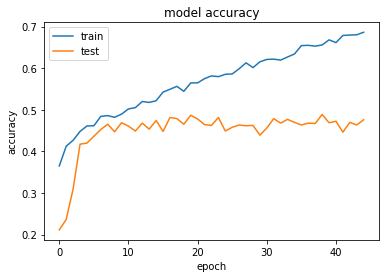

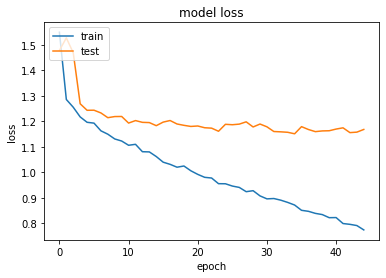

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
n_splits = 1  # We only want a single split in this case
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_resnet50.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=False)
for train_index, test_index in sss.split(X, y):
    yy = to_categorical(le.fit_transform(y))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = yy[train_index], yy[test_index]
    model = ResNet50()
    opt = keras.optimizers.Adam(learning_rate=0.000001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=150, verbose=1, callbacks=[es, mc])
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
saved_model = load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_resnet50.h5')


In [ ]:
#double check
import tensorflow as tf
from tensorflow import keras
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_resnet50.h5')

# Check its architecture
new_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 40, 517, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d_5 (ZeroPadding2  (None, 46, 523, 1)  0           ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 20, 259, 64)  3200        ['zero_padding2d_5[0][0]']       
                                                                                           

In [ ]:
new_model.metrics_names

['loss', 'accuracy']

In [ ]:
new_model.evaluate(X[1000:5000], yy[1000:5000], verbose=0)

[0.5109596848487854, 0.8452500104904175]

#Application


In [ ]:
!pip install ffmpeg-python
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    bitsPerSecond: 22050, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
def record_audio():  
  audio, sr = get_audio()
  samples_orig = audio.shape[0]/48000
  print(f'duration is {samples_orig}')
  if(samples_orig > 12):
    audio = audio[:12*48000]
  else:
    N_pad = abs(12*48000-audio.shape[0])
    print(N_pad/48000)
    audio = np.hstack((audio,np.zeros(N_pad)))
  print(audio.shape[0]/48000)
  arr = np.array(audio).astype(np.float32)
  arr = librosa.resample(arr, orig_sr=48000, target_sr=22050)
  import librosa.display
  plt.title('Recorded audio')
  librosa.display.waveplot(arr, sr= 22050)
  mfccs = librosa.feature.mfcc(y=arr, sr=22050, n_mfcc = 40)
  # mfccs = librosa.feature.mfcc(y=arr, sr=48000, n_mfcc = 40)
  plt.figure(figsize=(8,8))
  librosa.display.specshow(mfccs, sr=22050, x_axis='time')
  return mfccs

In [ ]:
import tensorflow as tf
from tensorflow import keras
lstmmodel = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/lstm_model.h5')

In [ ]:
mfccsT = mfccs.T

In [ ]:
mfccs.shape

(40, 517)

In [ ]:
def classify(mfccs, model,isTranspose=False): 
  labels = ['angry','happy','neutral','sad']
  if(isTranspose):
    temparr =  model.predict(mfccsT.reshape(1,517,40))
  temparr =  model.predict(mfccsT.reshape(1,40,517))
  print(f'Emotion of the speech most possibly is ... {labels[np.argmax(temparr)]}')

In [ ]:
temparr

array([[0.21072368, 0.18425313, 0.20457797, 0.40044516]], dtype=float32)

In [ ]:
temparr

array([[1.0000000e+00, 3.4276347e-08, 1.1277212e-08, 1.7590937e-33]],
      dtype=float32)

#Custom Resnet


In [13]:
def custom_resnet(input_shape=(40,517,1), classes=4):
  inputs = keras.Input(shape=input_shape, name="mfccs")
  x = layers.Conv2D(32, 8, activation="relu")(inputs)
  x = layers.Conv2D(64, 8, activation="relu")(x)
  block_1_output = layers.MaxPooling2D(3)(x)

  x = layers.Conv2D(64, 5, activation="relu", padding="same")(block_1_output)
  x = layers.Conv2D(64, 5, activation="relu", padding="same")(x)
  block_2_output = layers.add([x, block_1_output])

  x = layers.Conv2D(64, 5, activation="relu", padding="same")(block_2_output)
  x = layers.Conv2D(64, 5, activation="relu", padding="same")(x)
  block_3_output = layers.add([x, block_2_output])

  x = layers.Conv2D(64, 5, activation="relu", padding="same")(block_3_output)
  x = layers.Conv2D(64, 5, activation="relu", padding="same")(x)
  block_4_output = layers.add([x, block_3_output])

  x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_4_output)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  
  block_5_output = layers.add([x, block_4_output])

  x = layers.Conv2D(64, 3, activation="relu")(block_5_output)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation="relu")(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(classes, activation = 'softmax')(x)

  model = keras.Model(inputs, outputs, name="custom_resnet")
  return model

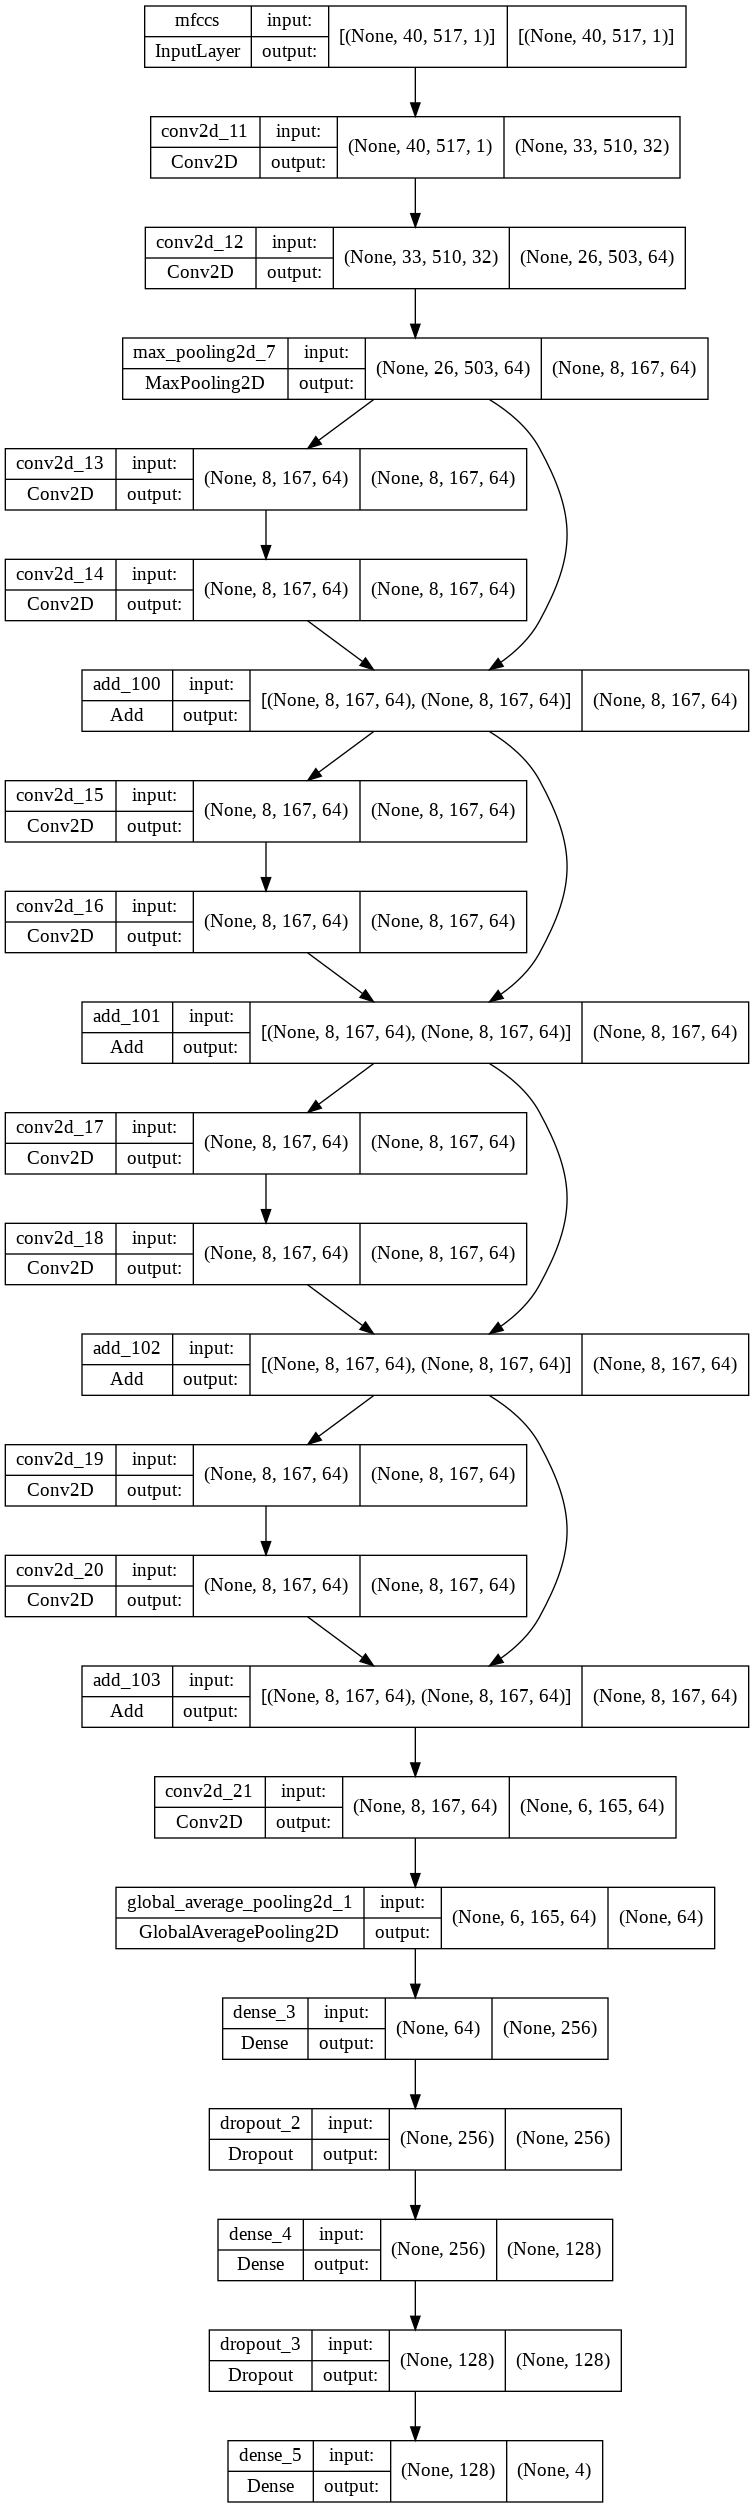

In [ ]:
keras.utils.plot_model(custom_resnet(), "/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/resnet.png", show_shapes=True)

In [ ]:
custom_resnet().summary()

Model: "custom_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfccs (InputLayer)             [(None, 40, 517, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 33, 510, 32)  2080        ['mfccs[0][0]']                  
                                                                                                  
 conv2d_23 (Conv2D)             (None, 26, 503, 64)  131136      ['conv2d_22[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 8, 167, 64)  0           ['conv2d_23[0][0]']  

In [ ]:
def k_fold_fit_re(model_type, X, yy, lr = 0.0001, folds=10, numepoch = 50, batchsize = 32):
  from sklearn.model_selection import KFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from tensorflow.keras.optimizers import SGD
  from sklearn.metrics import f1_score
  from functools import reduce
  #pred and ground truth for overall conf matrix
  truth = []
  predicted = []
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=folds, shuffle=True)
  fold_no = 1
  for train, test in kfold.split(X, yy):
    model = custom_resnet()
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(X[train],
                yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate(X[test], yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix construction
    y_pred = np.argmax(model.predict(X[test]), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #append predicted and ground truth to corresponding lists
    truth.append(yy[test].argmax(axis=1).tolist())
    predicted.append(y_pred.tolist())
    #conf matrix contd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')
  #flatten the nested lists
  print('Confusion matrix over all folders')
  truth = reduce(lambda x,y: x+y, truth)
  predicted = reduce(lambda x,y:x+y, predicted)
  matrix = metrics.confusion_matrix(truth, predicted)
  rounded_labels= np.unique(le.inverse_transform(np.argmax(yy, axis=1)))
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/80
156/156 [==============================] - 6s 35ms/step - loss: 1.4232 - accuracy: 0.2783
Epoch 2/80
156/156 [==============================] - 5s 35ms/step - loss: 1.3319 - accuracy: 0.3474
Epoch 3/80
156/156 [==============================] - 5s 35ms/step - loss: 1.2682 - accuracy: 0.3966
Epoch 4/80
156/156 [==============================] - 5s 35ms/step - loss: 1.2084 - accuracy: 0.4372
Epoch 5/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1709 - accuracy: 0.4581
Epoch 6/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1462 - accuracy: 0.4732
Epoch 7/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1349 - accuracy: 0.4800
Epoch 8/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1105 - accuracy: 0.4977
Epoch 9/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1046 - accuracy: 0

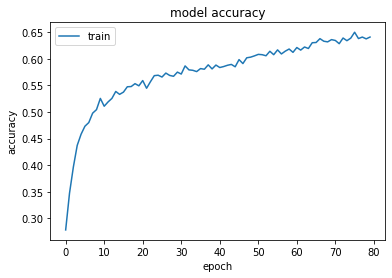

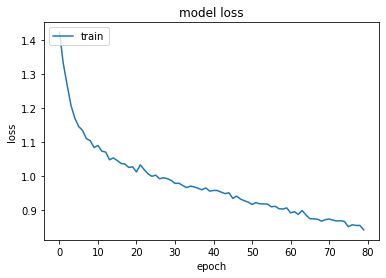

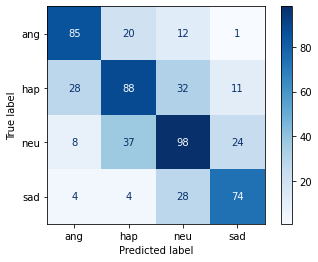

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 62.27436661720276 (+- 0.0)
> Loss: 0.879275918006897
> F1: 62.19064614179245
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/80
156/156 [==============================] - 6s 35ms/step - loss: 1.4686 - accuracy: 0.2901
Epoch 2/80
156/156 [==============================] - 5s 35ms/step - loss: 1.3396 - accuracy: 0.3431
Epoch 3/80
156/156 [==============================] - 5s 35ms/step - loss: 1.2752 - accuracy: 0.3994
Epoch 4/80
156/156 [==============================] - 5s 35ms/step - loss: 1.2317 - 

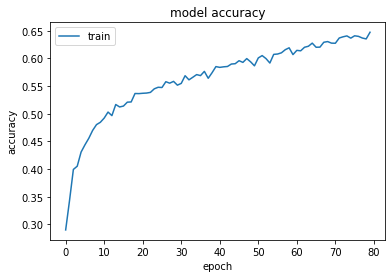

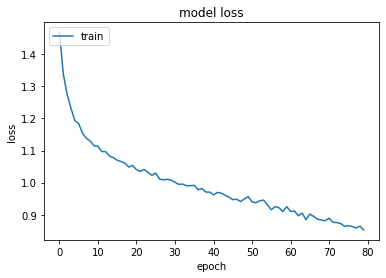

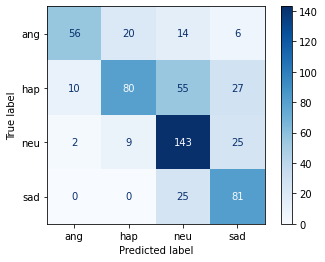

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8511732220649719 - Accuracy: 65.0994598865509% - F1: 64.49352885870194
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 63.68691325187683 (+- 1.4125466346740723)
> Loss: 0.8652245700359344
> F1: 63.34208750024719
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/80
156/156 [==============================] - 6s 35ms/step - loss: 1.5047 - accuracy: 0.2806
Epoch 2/80
156/156 [==============================] - 5s 35ms/step - loss: 1.3475 - accuracy: 0.3433
Epoch 

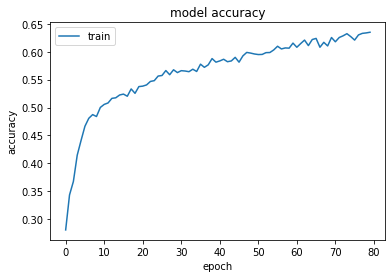

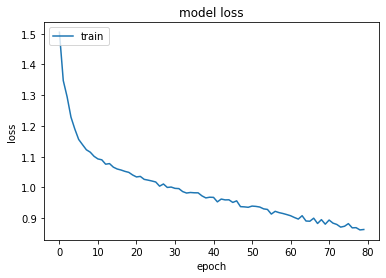

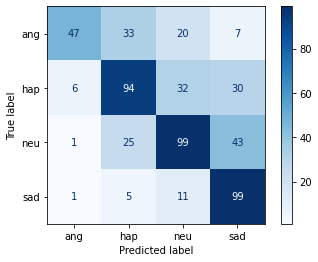

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8511732220649719 - Accuracy: 65.0994598865509% - F1: 64.49352885870194
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9070461988449097 - Accuracy: 61.30198836326599% - F1: 60.798806709530815
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 62.89193828900655 (+- 1.6106403633132704)
> Loss: 0.8791651129722595
> F1: 62.49432723667507
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/80
156/156 [=======================

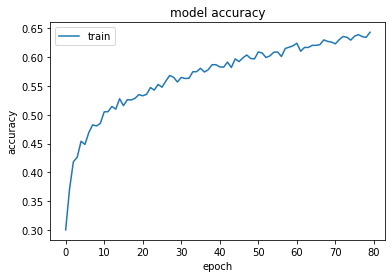

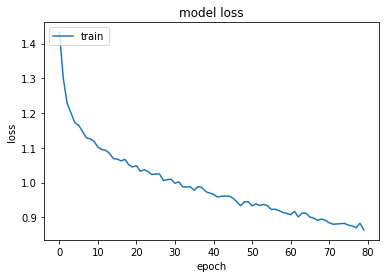

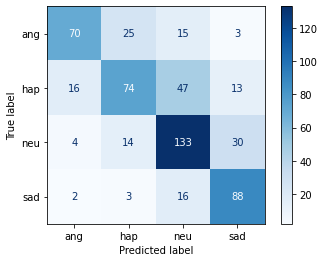

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8511732220649719 - Accuracy: 65.0994598865509% - F1: 64.49352885870194
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9070461988449097 - Accuracy: 61.30198836326599% - F1: 60.798806709530815
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8343037962913513 - Accuracy: 66.00361466407776% - F1: 65.53296726092228
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 63.66985738277435 (+- 1.9393545664204836)
> Loss: 0.8679497838020325
> F1: 63.25398724273687
-------------------------------------------------

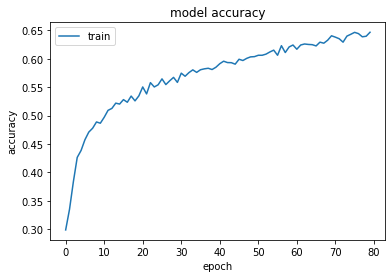

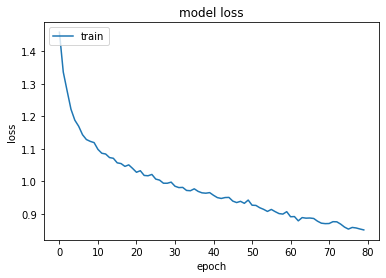

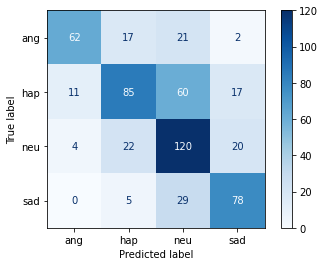

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8511732220649719 - Accuracy: 65.0994598865509% - F1: 64.49352885870194
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9070461988449097 - Accuracy: 61.30198836326599% - F1: 60.798806709530815
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8343037962913513 - Accuracy: 66.00361466407776% - F1: 65.53296726092228
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8961803913116455 - Accuracy: 62.386977672576904% - F1: 62.37727444391709
------------------------------------------------------------------------
Average scores for 

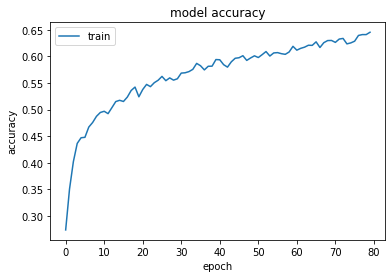

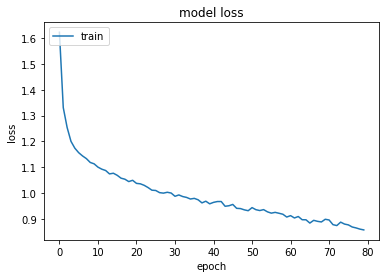

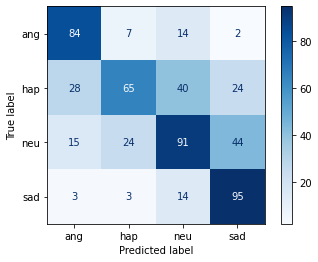

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8511732220649719 - Accuracy: 65.0994598865509% - F1: 64.49352885870194
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9070461988449097 - Accuracy: 61.30198836326599% - F1: 60.798806709530815
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8343037962913513 - Accuracy: 66.00361466407776% - F1: 65.53296726092228
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8961803913116455 - Accuracy: 62.386977672576904% - F1: 62.37727444391709
------------------------------------------------------------------------
> Fold 6 - Loss: 0.

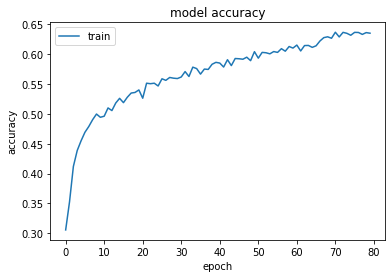

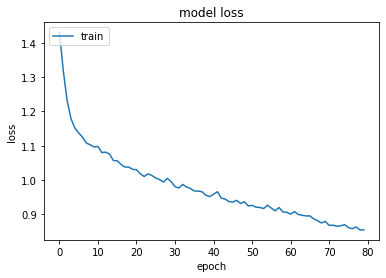

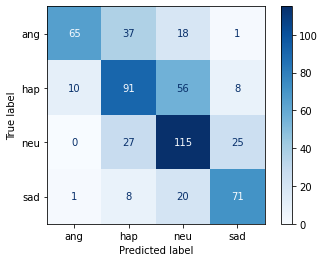

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8511732220649719 - Accuracy: 65.0994598865509% - F1: 64.49352885870194
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9070461988449097 - Accuracy: 61.30198836326599% - F1: 60.798806709530815
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8343037962913513 - Accuracy: 66.00361466407776% - F1: 65.53296726092228
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8961803913116455 - Accuracy: 62.386977672576904% - F1: 62.37727444391709
------------------------------------------------------------------------
> Fold 6 - Loss: 0.

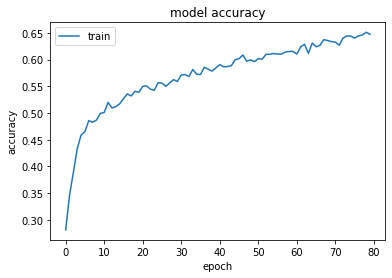

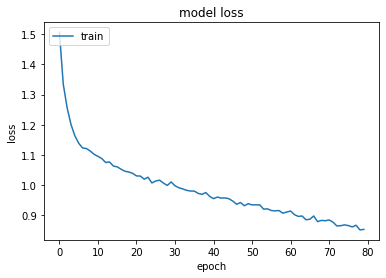

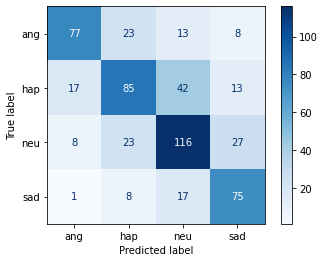

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8511732220649719 - Accuracy: 65.0994598865509% - F1: 64.49352885870194
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9070461988449097 - Accuracy: 61.30198836326599% - F1: 60.798806709530815
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8343037962913513 - Accuracy: 66.00361466407776% - F1: 65.53296726092228
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8961803913116455 - Accuracy: 62.386977672576904% - F1: 62.37727444391709
------------------------------------------------------------------------
> Fold 6 - Loss: 0.

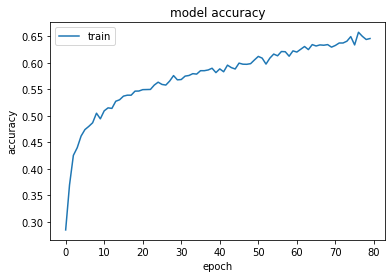

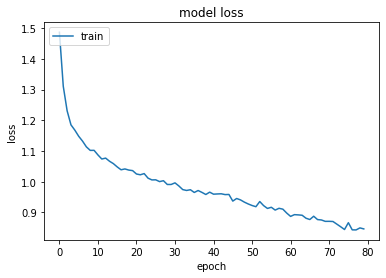

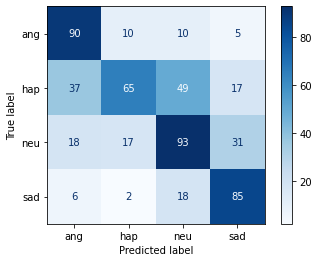

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8511732220649719 - Accuracy: 65.0994598865509% - F1: 64.49352885870194
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9070461988449097 - Accuracy: 61.30198836326599% - F1: 60.798806709530815
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8343037962913513 - Accuracy: 66.00361466407776% - F1: 65.53296726092228
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8961803913116455 - Accuracy: 62.386977672576904% - F1: 62.37727444391709
------------------------------------------------------------------------
> Fold 6 - Loss: 0.

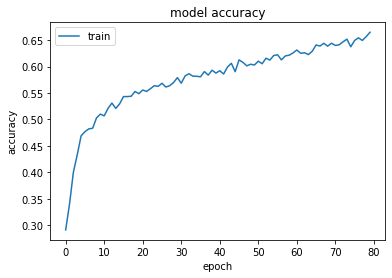

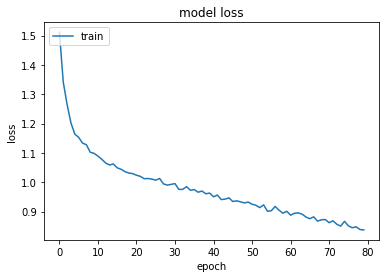

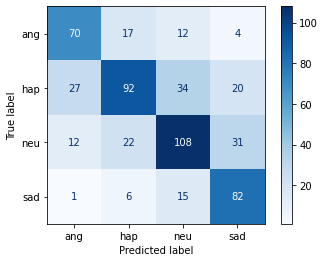

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.879275918006897 - Accuracy: 62.27436661720276% - F1: 62.19064614179245
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8511732220649719 - Accuracy: 65.0994598865509% - F1: 64.49352885870194
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9070461988449097 - Accuracy: 61.30198836326599% - F1: 60.798806709530815
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8343037962913513 - Accuracy: 66.00361466407776% - F1: 65.53296726092228
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8961803913116455 - Accuracy: 62.386977672576904% - F1: 62.37727444391709
------------------------------------------------------------------------
> Fold 6 - Loss: 0.

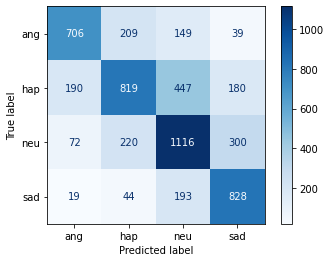

In [ ]:
k_fold_fit_re('Resnet_custom', X, yy, folds=10, lr=0.00001, numepoch = 80, batchsize = 32)

In [ ]:
def strat_k_fold_fit_re(model_type,X, yy, folds=10, lr=0.0001, numepoch = 50, batchsize = 32):
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from tensorflow.keras.optimizers import SGD
  from sklearn.preprocessing import LabelEncoder
  from sklearn.metrics import f1_score
  le = LabelEncoder()
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  # Define the stratified K-fold Cross Validator
  kfold = StratifiedKFold(n_splits=folds, shuffle=True)
  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(X, y):
    #label encoding comes after the split
    yy = to_categorical(le.fit_transform(y))
    model = custom_resnet()
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model and save details to history
    history = model.fit(X[train], yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate(X[test], yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix
    y_pred = np.argmax(model.predict(X[test]), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #conf matrix ctnd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/80
156/156 [==============================] - 6s 35ms/step - loss: 1.5657 - accuracy: 0.2727
Epoch 2/80
156/156 [==============================] - 5s 35ms/step - loss: 1.3242 - accuracy: 0.3560
Epoch 3/80
156/156 [==============================] - 5s 35ms/step - loss: 1.2580 - accuracy: 0.3910
Epoch 4/80
156/156 [==============================] - 5s 35ms/step - loss: 1.2001 - accuracy: 0.4356
Epoch 5/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1722 - accuracy: 0.4475
Epoch 6/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1473 - accuracy: 0.4808
Epoch 7/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1352 - accuracy: 0.4798
Epoch 8/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1211 - accuracy: 0.4868
Epoch 9/80
156/156 [==============================] - 5s 35ms/step - loss: 1.1145 - accuracy: 0

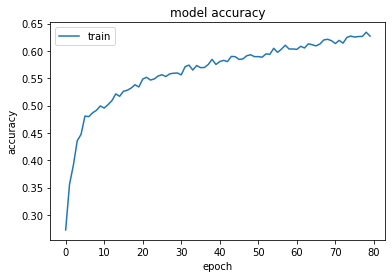

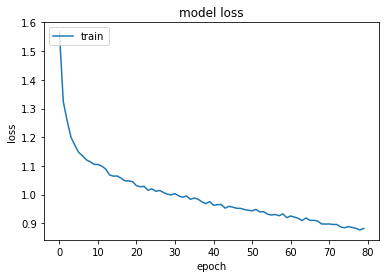

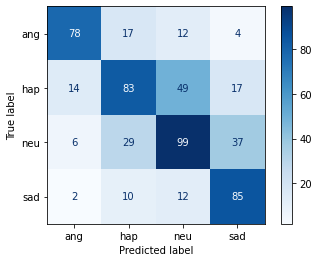

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 62.27436661720276 (+- 0.0)
> Loss: 0.9060759544372559
> F1: 62.07680387998254
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/80
156/156 [==============================] - 6s 35ms/step - loss: 1.5442 - accuracy: 0.2969
Epoch 2/80
156/156 [==============================] - 5s 35ms/step - loss: 1.3583 - accuracy: 0.3264
Epoch 3/80
156/156 [==============================] - 5s 35ms/step - loss: 1.2975 - accuracy: 0.3718
Epoch 4/80
156/156 [==============================] - 5s 35ms/step - loss: 1.2405

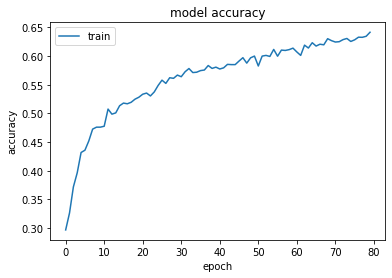

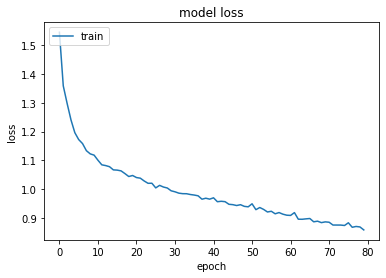

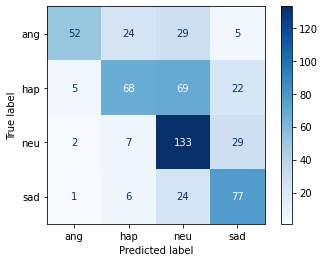

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9709109663963318 - Accuracy: 59.67450141906738% - F1: 58.95039996535747%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 60.97443401813507 (+- 1.299932599067688)
> Loss: 0.9384934604167938
> F1: 60.513601922670006
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/80
156/156 [==============================] - 6s 35ms/step - loss: 1.6450 - accuracy: 0.2684
Epoch 2/80
156/156 [==============================] - 5s 35ms/step - loss: 1.3589 - accuracy: 0.3270
Ep

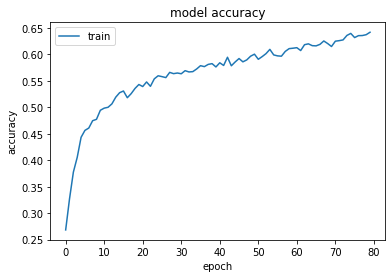

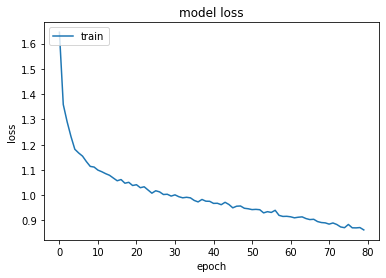

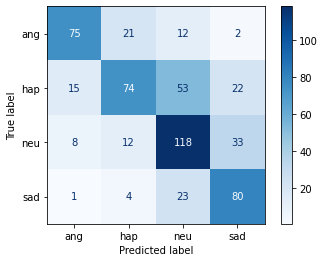

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9709109663963318 - Accuracy: 59.67450141906738% - F1: 58.95039996535747%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8629149198532104 - Accuracy: 62.74864673614502% - F1: 62.34808167919802%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 61.56583825747172 (+- 1.3513207576379875)
> Loss: 0.913300613562266
> F1: 61.125095174846
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/80
156/156 [======================

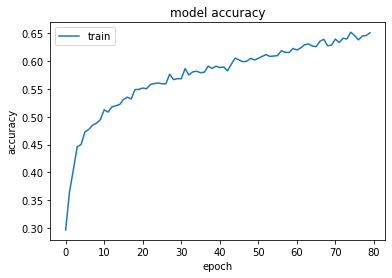

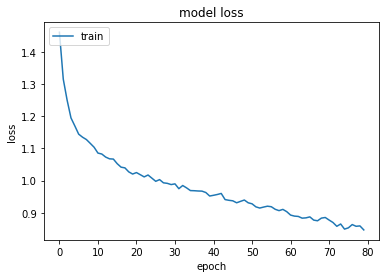

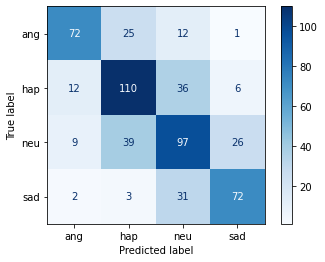

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9709109663963318 - Accuracy: 59.67450141906738% - F1: 58.95039996535747%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8629149198532104 - Accuracy: 62.74864673614502% - F1: 62.34808167919802%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8469284176826477 - Accuracy: 63.471972942352295% - F1: 63.59695014075527%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 62.042371928691864 (+- 1.4320627995786785)
> Loss: 0.8967075645923615
> F1: 61.74305891632332
------------------------------------------

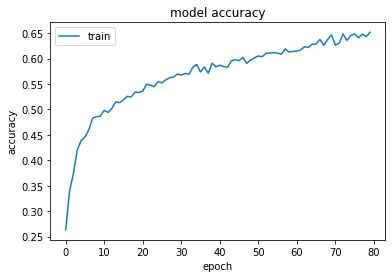

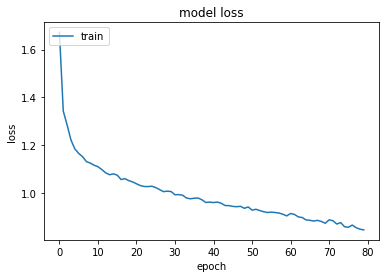

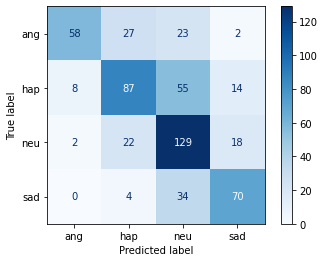

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9709109663963318 - Accuracy: 59.67450141906738% - F1: 58.95039996535747%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8629149198532104 - Accuracy: 62.74864673614502% - F1: 62.34808167919802%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8469284176826477 - Accuracy: 63.471972942352295% - F1: 63.59695014075527%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8903558850288391 - Accuracy: 62.206149101257324% - F1: 62.198389385150875%
------------------------------------------------------------------------
Average sco

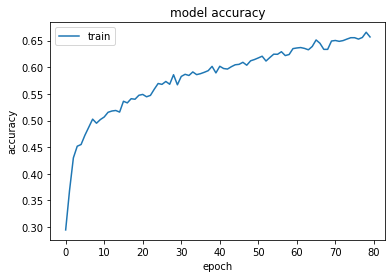

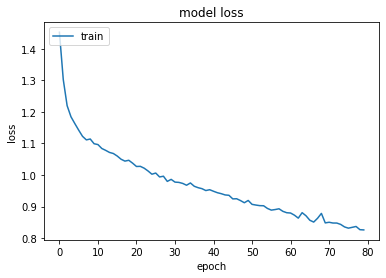

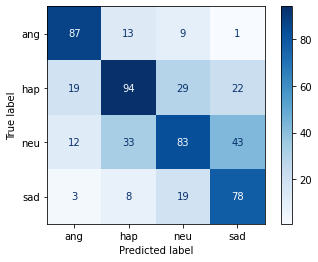

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9709109663963318 - Accuracy: 59.67450141906738% - F1: 58.95039996535747%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8629149198532104 - Accuracy: 62.74864673614502% - F1: 62.34808167919802%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8469284176826477 - Accuracy: 63.471972942352295% - F1: 63.59695014075527%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8903558850288391 - Accuracy: 62.206149101257324% - F1: 62.198389385150875%
------------------------------------------------------------------------
> Fold 6 - 

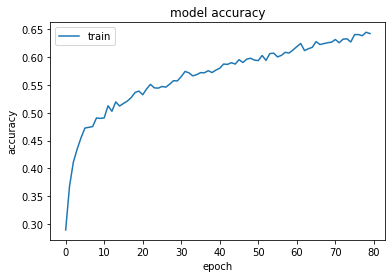

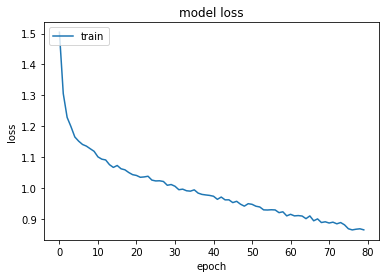

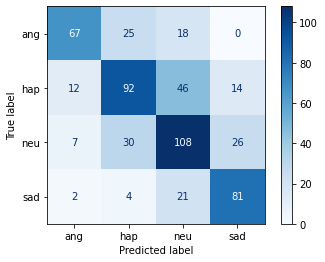

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9709109663963318 - Accuracy: 59.67450141906738% - F1: 58.95039996535747%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8629149198532104 - Accuracy: 62.74864673614502% - F1: 62.34808167919802%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8469284176826477 - Accuracy: 63.471972942352295% - F1: 63.59695014075527%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8903558850288391 - Accuracy: 62.206149101257324% - F1: 62.198389385150875%
------------------------------------------------------------------------
> Fold 6 - 

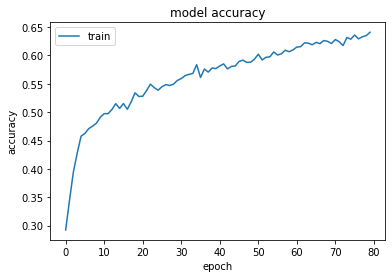

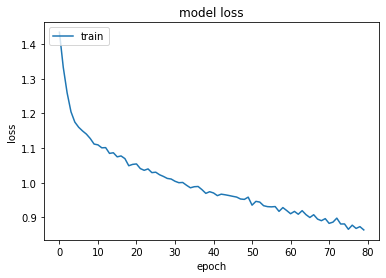

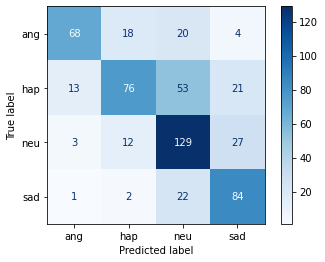

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9709109663963318 - Accuracy: 59.67450141906738% - F1: 58.95039996535747%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8629149198532104 - Accuracy: 62.74864673614502% - F1: 62.34808167919802%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8469284176826477 - Accuracy: 63.471972942352295% - F1: 63.59695014075527%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8903558850288391 - Accuracy: 62.206149101257324% - F1: 62.198389385150875%
------------------------------------------------------------------------
> Fold 6 - 

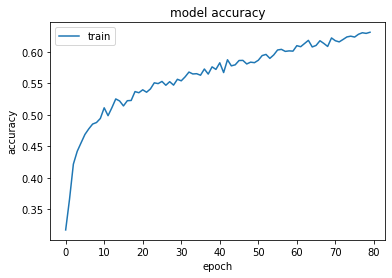

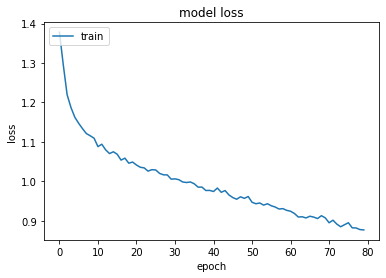

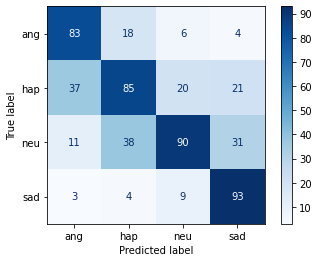

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9709109663963318 - Accuracy: 59.67450141906738% - F1: 58.95039996535747%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8629149198532104 - Accuracy: 62.74864673614502% - F1: 62.34808167919802%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8469284176826477 - Accuracy: 63.471972942352295% - F1: 63.59695014075527%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8903558850288391 - Accuracy: 62.206149101257324% - F1: 62.198389385150875%
------------------------------------------------------------------------
> Fold 6 - 

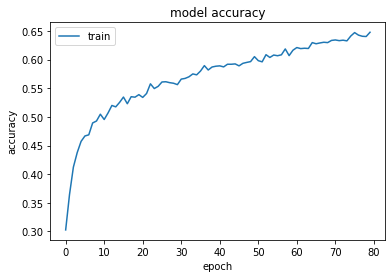

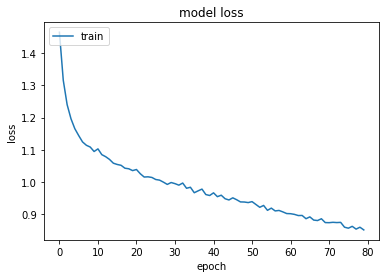

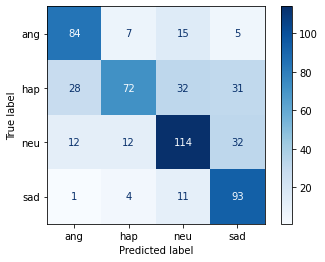

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9060759544372559 - Accuracy: 62.27436661720276% - F1: 62.07680387998254%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9709109663963318 - Accuracy: 59.67450141906738% - F1: 58.95039996535747%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8629149198532104 - Accuracy: 62.74864673614502% - F1: 62.34808167919802%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8469284176826477 - Accuracy: 63.471972942352295% - F1: 63.59695014075527%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8903558850288391 - Accuracy: 62.206149101257324% - F1: 62.198389385150875%
------------------------------------------------------------------------
> Fold 6 - 

In [ ]:
strat_k_fold_fit_re('Resnet_custom', X, yy, folds=10, lr=0.00001, numepoch = 80, batchsize = 32)

#Trainig over the whole dataset.
##Remark 80% of the dataset


Epoch 1/150
139/139 [==============================] - ETA: 0s - loss: 1.3987 - accuracy: 0.2993
Epoch 1: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/custom_resnet.h5
139/139 [==============================] - 7s 41ms/step - loss: 1.3987 - accuracy: 0.2993 - val_loss: 1.3201 - val_accuracy: 0.3695
Epoch 2/150
139/139 [==============================] - ETA: 0s - loss: 1.3110 - accuracy: 0.3628
Epoch 2: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/custom_resnet.h5
139/139 [==============================] - 5s 39ms/step - loss: 1.3110 - accuracy: 0.3628 - val_loss: 1.2535 - val_accuracy: 0.4074
Epoch 3/150
139/139 [==============================] - ETA: 0s - loss: 1.2492 - accuracy: 0.3960
Epoch 3: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/custom_resnet.h5
139/139 [==============================] - 5s 39ms/step - loss: 1.2492 - accuracy: 0.3960 - va

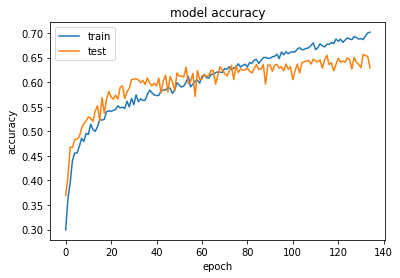

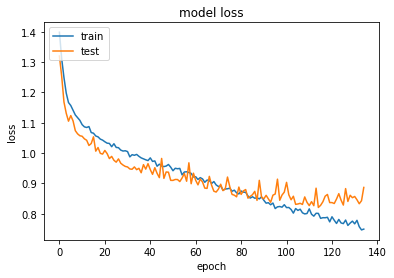

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
n_splits = 1  # We only want a single split in this case
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/custom_resnet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=False)
for train_index, test_index in sss.split(X, y):
    yy = to_categorical(le.fit_transform(y))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = yy[train_index], yy[test_index]
    model = custom_resnet()
    opt = keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=150, verbose=1, callbacks=[es, mc])
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
saved_model = load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/custom_resnet.h5')

duration is 6.54
5.46
12.0


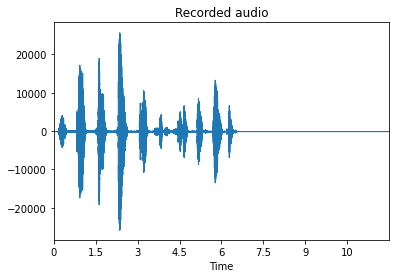

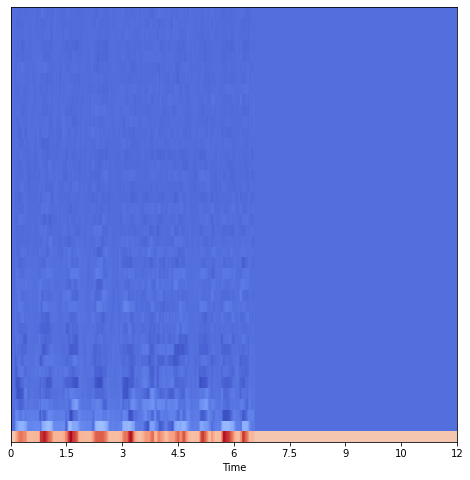

In [ ]:
audio, sr = get_audio()
samples_orig = audio.shape[0]/48000
print(f'duration is {samples_orig}')
if(samples_orig > 12):
  audio = audio[:12*48000]
else:
  N_pad = abs(12*48000-audio.shape[0])
  print(N_pad/48000)
  audio = np.hstack((audio,np.zeros(N_pad)))
print(audio.shape[0]/48000)
arr = np.array(audio).astype(np.float32)
arr = librosa.resample(arr, orig_sr=48000, target_sr=22050)
import librosa.display
plt.title('Recorded audio')
librosa.display.waveplot(arr, sr= 22050)
mfccs = librosa.feature.mfcc(y=arr, sr=22050, n_mfcc = 40)
# mfccs = librosa.feature.mfcc(y=arr, sr=48000, n_mfcc = 40)
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=22050, x_axis='time')

In [ ]:
labels = ['angry','happy','neutral','sad']
# if(isTranspose):
  # temparr =  saved_model.predict(mfccsT.reshape(1,517,40))
temparr =  saved_model.predict(mfccsT.reshape(1,40,517))
print(f'Emotion of the speech most possibly is ... {labels[np.argmax(temparr)]}')
print(temparr)

Emotion of the speech most possibly is ... angry
[[1.0000000e+00 3.7749395e-15 0.0000000e+00 1.4724617e-31]]


#Training without early stopping


In [11]:
model = ResNet50()
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt)
history = model.fit(X, yy,
                batch_size=32,
                epochs=100,
                verbose=1)

Epoch 1/100
173/173 [==============================] - 17s 64ms/step - loss: 1.3054
Epoch 2/100
173/173 [==============================] - 11s 64ms/step - loss: 1.2026
Epoch 3/100
173/173 [==============================] - 11s 64ms/step - loss: 1.1368
Epoch 4/100
173/173 [==============================] - 11s 64ms/step - loss: 1.1162
Epoch 5/100
173/173 [==============================] - 11s 64ms/step - loss: 1.0893
Epoch 6/100
173/173 [==============================] - 11s 64ms/step - loss: 1.0384
Epoch 7/100
173/173 [==============================] - 11s 64ms/step - loss: 1.0280
Epoch 8/100
173/173 [==============================] - 11s 64ms/step - loss: 0.9939
Epoch 9/100
173/173 [==============================] - 11s 64ms/step - loss: 0.9712
Epoch 10/100
173/173 [==============================] - 11s 64ms/step - loss: 0.9489
Epoch 11/100
173/173 [==============================] - 11s 64ms/step - loss: 0.8987
Epoch 12/100
173/173 [==============================] - 11s 64ms/step - lo

In [12]:
model.save('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/resnet50.h5') 

In [14]:
model = custom_resnet()
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt)
history = model.fit(X, yy,
                batch_size=32,
                epochs=100,
                verbose=1)

Epoch 1/100
173/173 [==============================] - 9s 39ms/step - loss: 1.6858
Epoch 2/100
173/173 [==============================] - 6s 35ms/step - loss: 1.3576
Epoch 3/100
173/173 [==============================] - 6s 35ms/step - loss: 1.2962
Epoch 4/100
173/173 [==============================] - 6s 35ms/step - loss: 1.2378
Epoch 5/100
173/173 [==============================] - 6s 35ms/step - loss: 1.1864
Epoch 6/100
173/173 [==============================] - 6s 35ms/step - loss: 1.1624
Epoch 7/100
173/173 [==============================] - 6s 35ms/step - loss: 1.1298
Epoch 8/100
173/173 [==============================] - 6s 35ms/step - loss: 1.1247
Epoch 9/100
173/173 [==============================] - 6s 35ms/step - loss: 1.1115
Epoch 10/100
173/173 [==============================] - 6s 35ms/step - loss: 1.0972
Epoch 11/100
173/173 [==============================] - 6s 35ms/step - loss: 1.0959
Epoch 12/100
173/173 [==============================] - 6s 35ms/step - loss: 1.0745
E

In [15]:
model.save('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/custom_res.h5') 